In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

import os 
import sys
local_path = os.path.abspath('')
sys.path.append(local_path)

In [2]:
import plotgenerator as pg
from model import *
from simulations import Simulator
from estimation import SMD

<h1> DP-life-cycle 

# 3 Solution

### See how input input data is interpolated

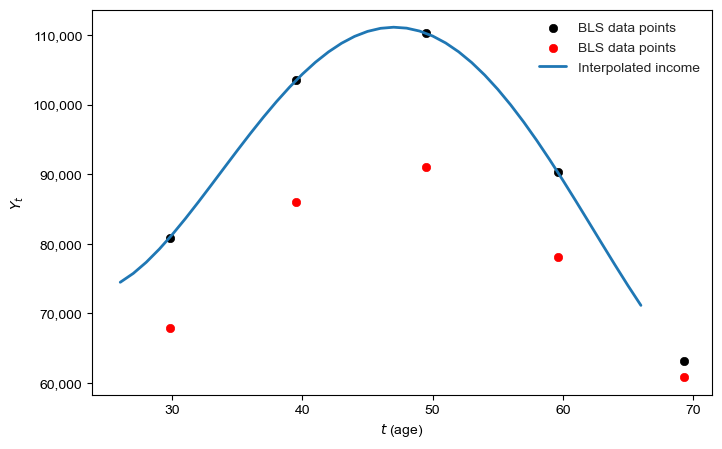

In [3]:
# Setup
model_data = gp_model() 
# Solve the model
model_data.solve_model()
# Simulate the model
sim_data = Simulator(model_data.par, model_data.sol).main()

# Plot the simulated data
fig = pg.PlotFigure(figsize=(8,5),fontname=None)
fig.add_plot(x=list(model_data.income_data.keys()),y=list(model_data.income_data.values()),marker='o',color='black',label='BLS data points',xlabel=f"$t$ (age)",ylabel=f"$Y_t$")
fig.add_plot(x=list(model_data.consumption_data.keys()),y=list(model_data.consumption_data.values()),marker='o',color='red',label='BLS data points')
fig.add_plot(x=model_data.grid_age,y=model_data.Ybar,linestyle='-',label='Interpolated income')
fig.add_legend()
fig.set_number_format('y','{x:,.0f}')
fig.show()

## Calibration of parameters

### Figure 1: Income proces, Gt

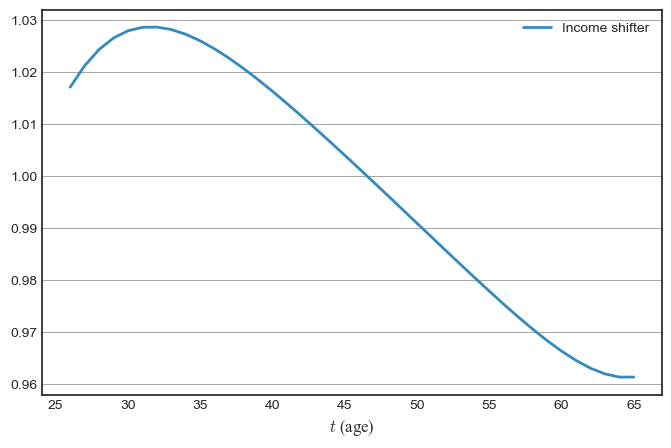

In [4]:
fig = pg.PlotFigure(figsize=(8,5),fontname='Times New Roman')
fig.add_plot(model_data.grid_age[:-1],model_data.par.G, label=f"Income shifter", linestyle='-',axis='y1')
fig.set_xlabel(f"$t$ (age)")
fig.add_legend()
fig.add_gridlines(axis='y')
fig.show()

## Results

### Solution to the model

In [5]:
def solve_model(par_dict):
    model = gp_model(**par_dict)
    model.solve_model()
    return model

model_init_sol = solve_model({'share':1})


### Figure 2: Shows the valuefunction for different discount factor. Middle panel shows the solution for the baseline calibration

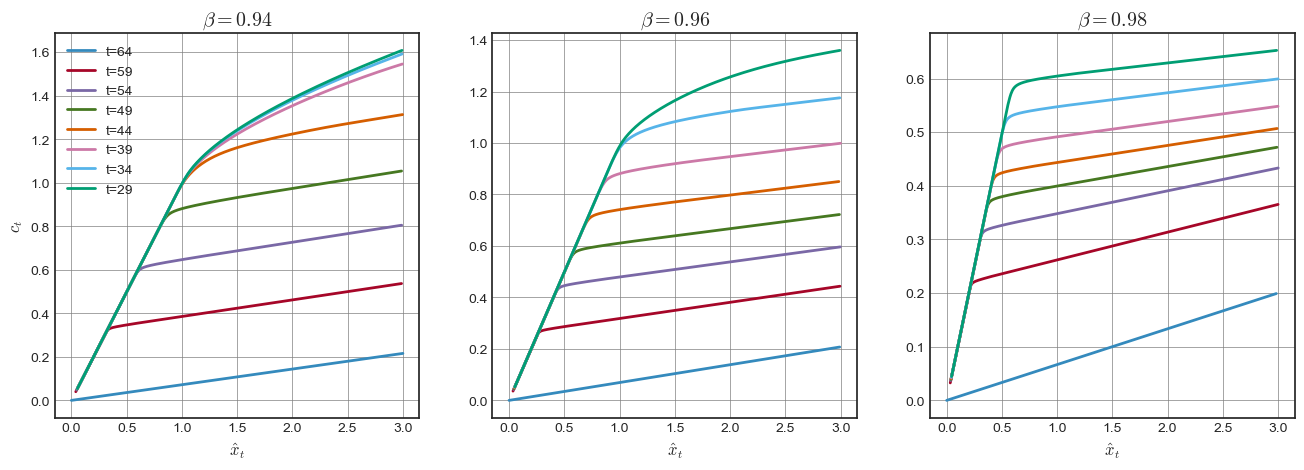

In [6]:
consumer = 0
rhos = [{'beta':0.94},{'beta':0.96},{'beta':0.98}]
fig = pg.PlotFigure(figsize=(16,5),fontname='Arial',rows=1,cols=len(rhos))
for i, par in enumerate(rhos):
    model = solve_model(par)
    # Print consumption function
    fig.change_ax(i)
    for t in range(model.par.Tr_N-1,model.par.t0_N-1,-5):
        criteria = np.where(model.sol.x[:,t,consumer] <= 3, True, False)
        fig.add_plot(model.sol.x[criteria,t,consumer],model.sol.c[criteria,t,consumer], label=f"t={25+t}", linestyle='-')
    if i == 0: fig.set_ylabel(f"$c_t$"); fig.add_legend();
    fig.set_title(f"$\\beta={par['beta']}$")
    fig.set_xlabel("$\hat{x}_t$")
    fig.add_gridlines(axis='both')

fig.show()

## Simulation 

### Figure 3: Income and consumption path. Average consumption and income are the averages of all the random draws.

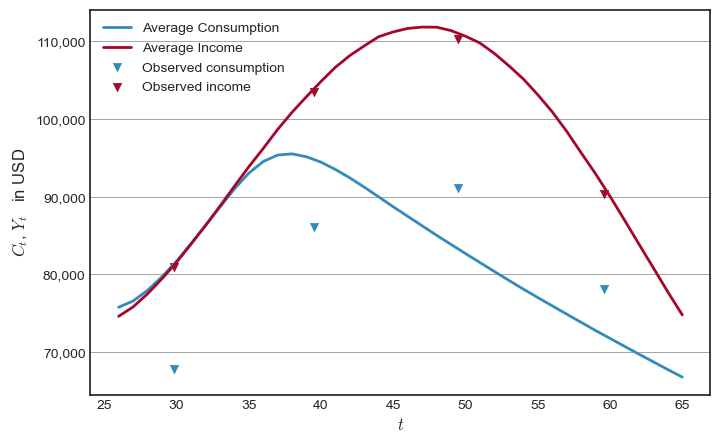

In [7]:
# s
sim = Simulator(model_init_sol.par, model_init_sol.sol).main()

obs_age = list(model_init_sol.income_data.keys())[:-1]
obs_income = list(model_init_sol.income_data.values())[:-1]
obs_consump = list(model_init_sol.consumption_data.values())[:-1]
# Plot simulation of the solution
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(model_init_sol.par.t0,model_init_sol.par.Tr)
fig.add_plot(x,sim.C_avg, label=f"Average Consumption", linestyle='-',axis='y1')
fig.add_plot(x,sim.Y_avg, label=f"Average Income", linestyle='-',axis='y1')
fig.add_plot(obs_age,obs_consump,label='Observed consumption', marker='v',axis='y1')
fig.add_plot(obs_age,obs_income,label='Observed income', marker='v',axis='y1')
fig.set_ylabel(f"$C_t$, $Y_t$   in USD")
fig.set_xlabel(f"$t$")
fig.set_number_format('y','{x:,.0f}')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

### shift in incomst motive

##### Decompose savings 

In [8]:
model_lc = gp_model(**{'sigma_eta': 0.0, 'sigma_mu':0.0,'pi':0,'xmin':-10.0})

# retirement rule
model_lc.main_setup()

# Solve the Life-cycle model
model_lc.solve_model()

# Simulate the Life-cycle model
sim_lc = Simulator(model_lc.par, model_lc.sol).main()

In [9]:
# Decomposition
consumer = 0
S_lc = np.mean(sim_lc.S[1:,:,consumer],axis=1)
W_lc = np.mean((sim_lc.P*sim_lc.a)[1:,:,consumer], axis=1)
S = np.mean(sim.S[1:,:,consumer],axis=1)
W = np.mean((sim.P*sim.a)[1:,:,consumer], axis=1)
S_b  = S - S_lc 
W_b = W - W_lc

### Figure 4: Left panel shows the savings decomposition: ”Total savings” refers to the savings at age t for the baseline model, ”Savings lifecycle” refers to the savings at age t for the life-cycle model, ”Savings bufferstock” is the difference between the two. The right panel shows the wealth in the same three situations 12


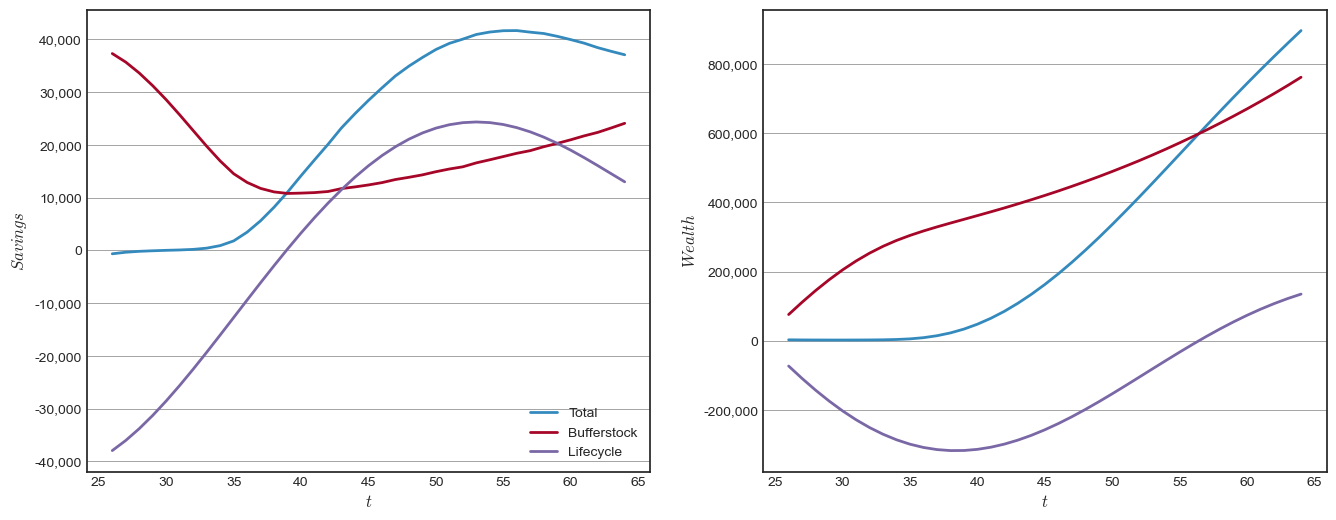

In [10]:
# Print consumption function
fig = pg.PlotFigure(figsize=(16,6),fontname='Arial',rows=1,cols=2)
x = range(0+model_init_sol.par.t0,len(S)+model_init_sol.par.t0)
fig.add_plot(x,S, label=f"Total", linestyle='-',axis='y1')
fig.add_plot(x,S_b, label=f"Bufferstock", linestyle='-',axis='y1')
fig.add_plot(x,S_lc, label=f"Lifecycle", linestyle='-',axis='y1')
fig.set_number_format('y','{x:,.0f}')
fig.set_ylabel(f"$Savings$")
fig.set_xlabel(f"$t$")
fig.add_legend()
fig.change_ax(1)
fig.add_plot(x,W, label=f"Total wealth", linestyle='-',axis='y1')
fig.add_plot(x,W_b, label=f"Wealth bufferstock", linestyle='-',axis='y1')
fig.add_plot(x,W_lc, label=f"Wealth lifecycle", linestyle='-',axis='y1')
fig.set_number_format('y','{x:,.0f}')
fig.set_ylabel(f"$Wealth$")
fig.set_xlabel(f"$t$")

fig.show()


# 4 Estimation

### Estimation based on random data

#### Data generation

In [11]:
# Setup params
beta = 0.95
rho = 0.45
model_dgp = gp_model(**{'beta':beta,'rho':rho})

# Solve the model
model_dgp.solve_model()

dgp_par = [model_dgp.par.beta, model_dgp.par.rho]
# 
sim_dgp = Simulator(model_dgp.par, model_dgp.sol).main()
input_data = np.log(sim_dgp.C_avg)


In [12]:
weight_mat_inv =  np.eye(input_data.size)   # The identity matrix and I^-1=I #np.diag(sim_dgp.C_var)
est = SMD(model=model_init_sol,simulator=Simulator, mom_data=input_data)

#### grid search - and plot the objective function for different values

In [13]:
est.beta_grid = np.arange(0.9,0.96,0.01)
est.rho_grid = np.arange(0.45,0.5,0.01)
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

#### estimation

In [14]:
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],bounds=None,W=weight_mat_inv, grid=False)

used optimizer:  nelder-mead


##### check of the models ability to replicated resolves

In [15]:
print(f'estimated values using grid method {np.around(est.est,4)} and true parameters {dgp_par}, with objective function value {est.est_out.fun:.2f}')

estimated values using grid method [0.95 0.45] and true parameters [0.95, 0.45], with objective function value 0.00


In [16]:
# Obtain the variance-covariance matrix
var_cov_matrix = est.estimate_variance_covariance_matrix(est.est, ['beta','rho'], W=weight_mat_inv)
print(var_cov_matrix)

[[-7.05191020e+20  1.84664413e+22]
 [ 1.84664413e+22 -4.83570328e+23]]


## Estimation results

### Estimation using data from BLS
For data look at the very top

In [17]:
# Setup
model_real = gp_model()

# input the data
real_data = model_real.Cbar[:-1] # Cbar has one more element than the grid_age

In [18]:
weight_mat_inv = np.eye(real_data.size)   # The identity matrix and I^-1=I
est_real = SMD(model=model_real,simulator=Simulator, mom_data=real_data)
est_real.age_groups = False

#### Estimation

In [19]:
est_real.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],bounds=None,W=weight_mat_inv,grid=False)

used optimizer:  nelder-mead


#### Estimated Discountfactor and Risk-aversion parameter $\left[\beta, \rho\right]$ based on BLS data 

#### Table 2: Parameter estimates of baseline

In [20]:
print(est_real.est_out.success)
print(f'estimated values {est_real.est} with objective function value {est_real.est_out.fun}')

True
estimated values [0.94578985 4.45436905] with objective function value 0.31081355082349593


In [21]:
# Obtain the optimal parameters
rho_opt = est_real.est[1]
beta_opt = est_real.est[0]
print(f'Optimal beta: {beta_opt}, Optimal rho: {rho_opt}')
# setup the model with the optimal parameters
model_fit = gp_model(**{'beta':beta_opt,'rho':rho_opt})
# solve model
model_fit.solve_model()

# 
sim_fit = Simulator(model_fit.par, model_fit.sol)
sim_fit = sim_fit.main()

Optimal beta: 0.9457898525437717, Optimal rho: 4.454369052654512


### Figure 5: The figure shows interpolated consumption values for the simulated model plotted against the consumption values for the actual data. The figure also plots the consumption values against the data for income

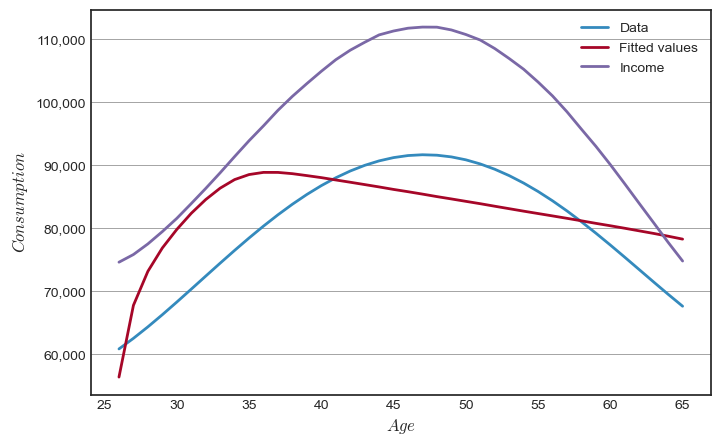

In [22]:
# plot the interpolated values
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
fig.add_plot(model_real.grid_age[:-1], np.exp(model_real.Cbar[:-1]), label=f"Data", linestyle='-')
fig.add_plot(model_real.grid_age[:-1], (sim_fit.C_avg), label=f"Fitted values", linestyle='-')
fig.add_plot(model_real.grid_age[:-1], (sim_fit.Y_avg), label=f"Income", linestyle='-')
fig.set_ylabel(f"$Consumption$")
fig.set_xlabel(f"$Age$")
fig.add_gridlines(axis='y')
fig.set_number_format('y','{x:,.0f}')
fig.add_legend()

fig.show()

## Sensitivity of estimates

### Table 3: Sensitivity of variable in column 1 to changes in variable in header

In [23]:
phi = ['r','gamma1','pi','sigma_eta','sigma_mu']
theta = ['beta','rho']
sens_mes = est_real.sensitivity(theta=theta, est_par=est_real.est, W=weight_mat_inv, phi_st=phi, step=1.0e-10)
for i, est_par in enumerate(theta):
    for j, cal_par in enumerate(phi):
        print(f"Sensitivity of {est_par} to {cal_par} is {sens_mes[i,j]:.3f}")

Sensitivity of beta to r is -0.023
Sensitivity of beta to gamma1 is 0.014
Sensitivity of beta to pi is 0.004
Sensitivity of beta to sigma_eta is -0.002
Sensitivity of beta to sigma_mu is -0.000
Sensitivity of rho to r is -0.487
Sensitivity of rho to gamma1 is -0.769
Sensitivity of rho to pi is -0.229
Sensitivity of rho to sigma_eta is -0.046
Sensitivity of rho to sigma_mu is -0.011


# 5 Extension


In [24]:
# Setup params
type1_beta = 0.96 # high beta type -- C1
type2_beta = 0.9  # low  beta type -- C2
share = 0.4 # share of type 1
rho = 0.45 # risk aversion parameter
dgp_par_ext = [type1_beta,type2_beta,rho,share]

model_types = gp_model(**{'beta':type1_beta,'beta2':type2_beta,'share':share,'rho':rho,})
# Solve the model
model_types.solve_model()
# Simulate the model
sim_types = Simulator(model_types.par, model_types.sol).main()

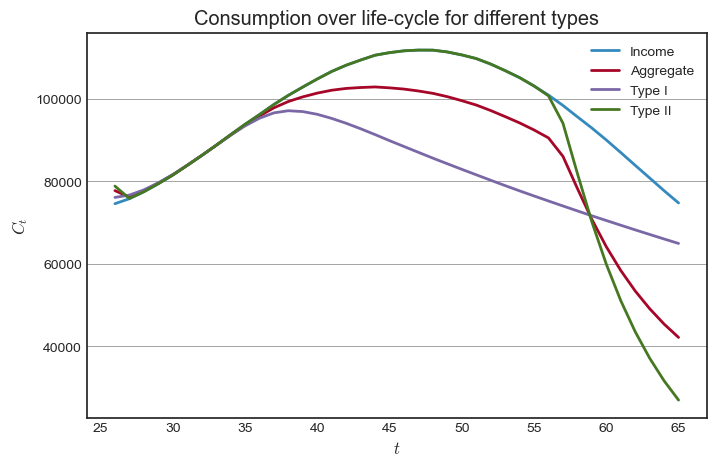

In [25]:
# plot consumption
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(model_types.par.t0,model_types.par.Tr)
fig.add_plot(x,sim_types.Y_avg, label=f"Income", linestyle='-',axis='y1')
fig.add_plot(x,sim_types.C_avg, label=f"Aggregate", linestyle='-',axis='y1')
fig.add_plot(x,sim_types.C_avg_type1, label=f"Type I", linestyle='-',axis='y1')
fig.add_plot(x,sim_types.C_avg_type2, label=f"Type II", linestyle='-',axis='y1')
fig.add_gridlines(axis='y')
fig.set_ylabel(f"$C_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption over life-cycle for different types')
fig.add_legend()
fig.show()


In [26]:
weight_mat_inv = np.eye(sim_types.C_avg.shape[0])   # The identity matrix and I^-1=I
est_ext = SMD(model=model_types,simulator=Simulator, mom_data=np.log(sim_types.C_avg))

In [27]:
constraint = lambda x: x[0] - x[1]
est_ext.estimate(theta0=[0.91,0.9,0.4,0.2],est_par=['beta','beta2','rho','share'],W=weight_mat_inv,bounds=[(0.01,0.99),(0.01,0.99),(0,10),(0,1)],constraint=constraint, grid=False)

used optimizer:  SLSQP


In [28]:
if est_ext.est_out.success:
    print(f'estimated values using scipy optimizer {np.around(est_ext.est,4)}, while true parameters are {dgp_par_ext}, with objective function value {est_ext.est_out.fun:.2f}')
else:
    print(f'optimization failed')

estimated values using scipy optimizer [0.96   0.8997 0.452  0.4   ], while true parameters are [0.96, 0.9, 0.45, 0.4], with objective function value 0.00


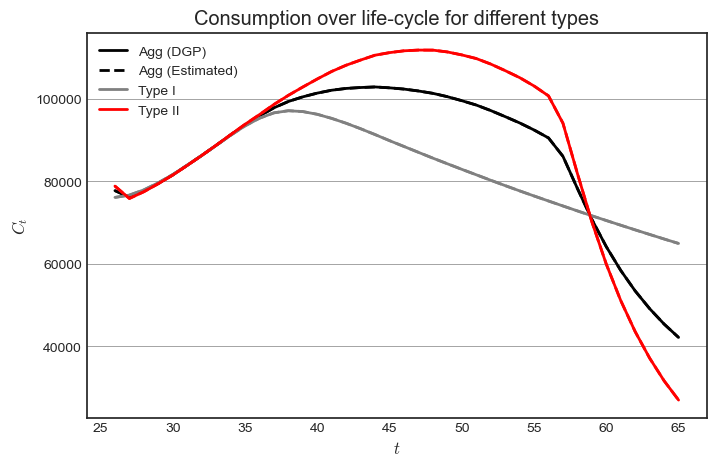

In [29]:
# simulate the model with the estimated parameters
model_fit_ext = gp_model(**{'beta':est_ext.est[0],'beta2':est_ext.est[1],'rho':est_ext.est[2],'share':est_ext.est[3]})
model_fit_ext.solve_model()
sim_fit_ext = Simulator(model_fit_ext.par, model_fit_ext.sol).main()

# plot the simulated values
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(model_types.par.t0,model_types.par.Tr)
fig.add_plot(x,sim_types.C_avg, label=f"Agg (DGP)", linestyle='-',color='black',axis='y1')
fig.add_plot(x,sim_fit_ext.C_avg, label=f"Agg (Estimated)", linestyle='--',color='black',axis='y1')

fig.add_plot(x,sim_types.C_avg_type1, label=f"Type I", linestyle='-',color='grey',axis='y1')
fig.add_plot(x,sim_fit_ext.C_avg_type1, linestyle='--',color='grey',axis='y1')

fig.add_plot(x,sim_types.C_avg_type2, label=f"Type II", linestyle='-',color='red',axis='y1')
fig.add_plot(x,sim_fit_ext.C_avg_type2, linestyle='--',color='red',axis='y1')


fig.add_gridlines(axis='y')
fig.set_ylabel(f"$C_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption over life-cycle for different types')
fig.add_legend()
#fig.show()


## Estimation based on extension

#### Estimated discount factors based on observed heterogeneity 

### Table 2: Parameter estimates of extended model.

In [30]:
est_ext = SMD(model=model_types,simulator=Simulator, mom_data=real_data)
constraint = lambda x: x[0] - x[1]
est_ext.estimate(theta0=[0.975,0.925,0.4,0.5],est_par=['beta','beta2','rho','share'],W=weight_mat_inv,bounds=[(0.01,0.99),(0.01,0.99),(0,10),(0,1)],constraint=constraint, grid=False)

used optimizer:  SLSQP


In [31]:
if est_ext.est_out.success:
    print(f'estimated values using scipy optimizer {np.around(est_ext.est,4)}')
else:
    print(f'optimization failed')

estimated values using scipy optimizer [0.99   0.8874 1.4014 0.4861]


### Figure 5: The figure shows interpolated consumption values for the simulated model plotted against the consumption values for the actual data. The figure also plots the consumption values against the data for income

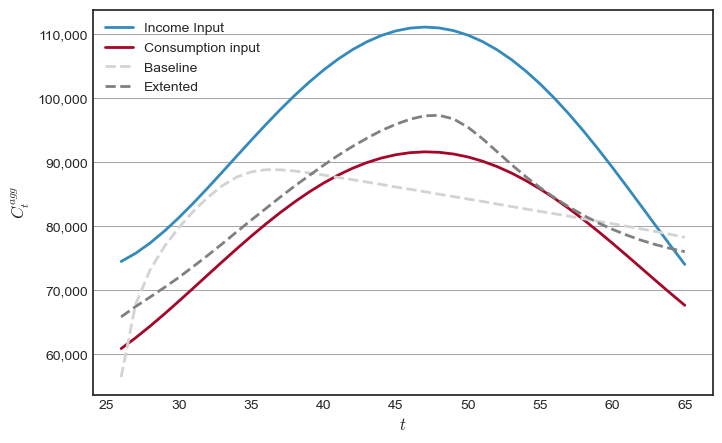

In [32]:
# simulate the model with the estimated parameters
model_fit_ext = gp_model(**{'beta':est_ext.est[0],'beta2':est_ext.est[1],'rho':est_ext.est[2],'share':est_ext.est[3]})
model_fit_ext.solve_model()
sim_fit_ext = Simulator(model_fit_ext.par, model_fit_ext.sol).main()

# plot the simulated values
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(model_types.par.t0,model_types.par.Tr)
fig.add_plot(x,model_data.Ybar[:-1], label=f"Income Input", linestyle='-',axis='y1')
fig.add_plot(x,np.exp(real_data), label=f"Consumption input", linestyle='-',axis='y1')
fig.add_plot(x,sim_fit.C_avg, label=f"Baseline", linestyle='--',color='lightgrey',axis='y1')
fig.add_plot(x,sim_fit_ext.C_avg, label=f"Extented", linestyle='--',color='grey',axis='y1')
fig.add_gridlines(axis='y')
fig.set_number_format('y','{x:,.0f}')
fig.set_ylabel("$C_t^{agg}$")
fig.set_xlabel("$t$")
fig.add_legend()

fig.show()
